## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


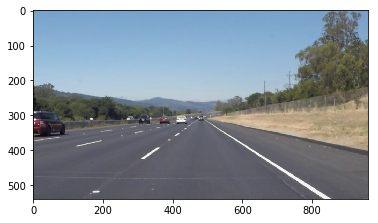

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def pick_lanes(lines):
    """
    Helper function to eliminate hough lines which are not part of road
    Assumption : Ignore line if slope magnitude is not in between 30 to 70 degrees
    Pick line pairs which have minimum angle difference
    """
    left_lanes = []
    right_lanes = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            # Ignore line if slope magnitude is not in between 30 to 70 degrees
            angle = ((y2-y1)/(x2-x1)) * (180/np.pi)
            
            if abs(angle) < 30 or abs(angle) > 70:
                continue
            
            # Left lane
            if(angle > 0):
                left_lanes.append((x1, y1, x2, y2, angle))
            
            # Right lane
            if(angle < 0):
                right_lanes.append((x1, y1, x2, y2, angle))
            
            #print(angle)
    
    lane_pair = []
    min = 1000
    
    for lx1, ly1, lx2, ly2, la in left_lanes:
        for rx1, ry1, rx2, ry2, ra in right_lanes:
            if abs(la + ra) < min:
                min = abs(la+ra)
                lane_pair = [(lx1, ly1, lx2, ly2, la), (rx1, ry1, rx2, ry2, ra)]
                
                # Extrapolate line pairs
                
                #add max and min points
                lslope = (ly2-ly1)/(lx2-lx1) + 0.0001
                rslope = (ry2-ry1)/(rx2-rx1) + 0.0001
                X_intercept_left= int(lx2-(ly2-img.shape[0])/lslope) #x2+y2-y1/m
                X_intercept_right= int(rx2-(ry2-img.shape[0])/rslope) #x2+y2-y1/m
                
                Y_top  = 330
                X_top_left = int(X_intercept_left + (Y_top-img.shape[0])/lslope)
                X_top_right =int(X_intercept_right + (Y_top-img.shape[0])/rslope)
                lane_pair = [(X_top_left, Y_top, X_intercept_left, img.shape[0], la), (X_top_right, Y_top, X_intercept_right, img.shape[0], ra)]
    
    return lane_pair

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    lane_pair = pick_lanes(lines)
    for x1,y1,x2,y2,a in lane_pair:
        cv2.line(img, (x1, y1), (x2, y2), color, thickness*4)
    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

# Test Images



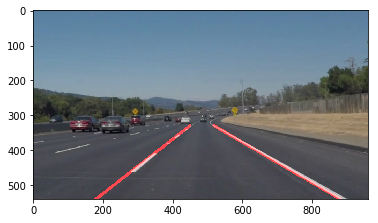

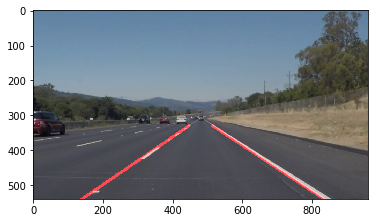

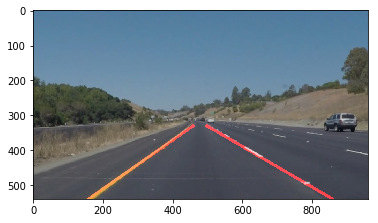

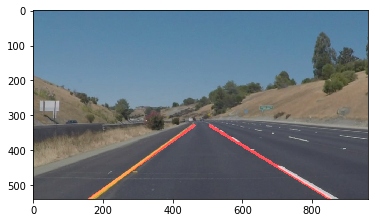

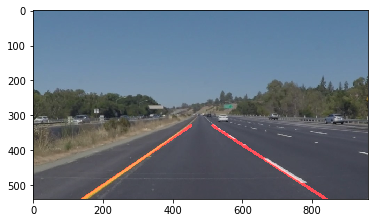

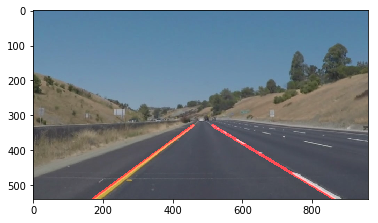

In [7]:
import os
import cv2


d = './test_images/'
out = './test_images_output/'
files = os.listdir(d)

kernel_size = 3

for f in files:
    name = os.path.join(d, f)
    
    # Read image and remove noise using Gaussian blur
    img = mpimg.imread(name)
    img_g = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    
    # Identify pixels below the threshold to create binary mask
    thresholds = (img_g[:,:,0] < 200) | (img_g[:,:,1] < 100) | (img_g[:,:,2] < 100)
    img_g[thresholds] = [0,0,0]
    
    # Run Edge detection algorithm
    img_edges = cv2.Canny(img_g, 30, 100)
    
    # Detect lines
    # Define the Hough transform parameters
    rho = 1
    theta = np.pi/180
    threshold = 30
    min_line_len = 30
    max_line_gap = 20
    line_img = hough_lines(img_edges, rho, theta, threshold, min_line_len, max_line_gap)
    
    # Draw lanes on input image
    lines_edges = weighted_img(line_img, img)
    
    # Save and display results
    plt.figure()
    plt.imshow(lines_edges, 'gray')
    outname = os.path.join(out, f)
    plt.imsave(outname,lines_edges)

    '''
    #cv2.imwrite(outname,lines_edges)
    #ycrcb = cv2.imread(name, cv2.COLOR_BGR2YCrCb)    
    #yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    #gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    # plt.imshow(yuv[:, :, 0], 'gray')
    # ret1,mask = cv2.threshold(img_g, 180, 255, cv2.THRESH_BINARY)
    # Threshold the RGB image to getwhite colors
    # mask = cv2.inRange(img, 100, 255)
    # Bitwise-AND mask and original image
    #res = cv2.bitwise_and(img, img, mask=mask)
    '''

## Build a Lane Finding Pipeline



In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
def process_image(image):
   
    # Apply Gaussian blur to remove noise
    img_g = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    
    # Identify pixels below the threshold
    thresholds = (img_g[:,:,0] < 200) | (img_g[:,:,1] < 100) | (img_g[:,:,2] < 100)
    img_g[thresholds] = [0,0,0]
    
    img_edges = cv2.Canny(img_g, 30, 100)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1
    theta = np.pi/180
    threshold = 30
    min_line_len = 30
    max_line_gap = 20
    line_image = hough_lines(img_edges, rho, theta, threshold, min_line_len, max_line_gap)
    
    # Overlay extrapolated lines
    lines_edges = weighted_img(line_image, image,1.0,0.95,0.0)

    return lines_edges

In [13]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:14<00:00, 15.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 11.6 s, sys: 914 ms, total: 12.5 s
Wall time: 15.3 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:19<00:00, 37.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 19.5 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [11]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:13<00:00, 19.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 14.1 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))